# General rundown
This notebook details the construction of the $C_\ell$ data vector for use in the main analysis, as well as the construction of the derivative vectors with respect to each cosmological parameter. Intitial forecasting is then done using the chainconsumer python library (big triangle plots)

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt

In [2]:
params_fiducial = {'Omega_c': 0.27,\
                           'Omega_b': 0.045,\
                           'h': 0.67,\
                           'A_s_norm': 2.1,\
                           'n_s': 0.96,\
                           'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
                           'w0': -0.9,\
                           'wa': 0,\
                           'mu_0': 0,\
                           'sigma_0': 0 }

In [3]:
def data_vector(params):
    '''This function takes a parameter argument which is a list of dictionaries used to vary one specific parameter,
    it then calculates the data vectors for each dict and plots them on the same matplotlib figure, allowing for the
    effects of varying each cosmological parameter on the data vectors form to be analysed'''
    
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          A_s = params['A_s_norm']*10**(-9),\
                          n_s = params['n_s'],\
                          w0 = params['w0'],\
                          wa = params['wa'],\
                          mu_0 = params['mu_0'],\
                          sigma_0 = params['sigma_0'],\
                          matter_power_spectrum = 'linear')
    
    #Load in lensing and clustering distributions and ell
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'][i]*np.ones(2000))))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo, dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1])))
    
    #Now that the tracers are constructed, calculate C_l's for shear, gg-lensing and lensing
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    

    for i in range(len(tracers_clust)):
        
        cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
        
        for j in range(len(tracers_clust)):
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    for n in range(len(gglensing)):
        if gglensing[n] == 1:
            cls_gg_clean.append(cls_gg[n])

    #Clean up the data vectors shapes and combine them all
    cls_clus_gg = np.append(cls_clus, cls_gg_clean)
    cls_combined = np.append(cls_clus_gg, cls_lens)
    
    return cls_combined

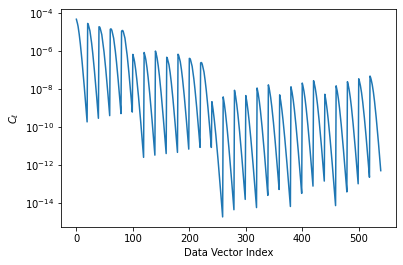

In [4]:
data_vector_fiducial = data_vector(params_fiducial)

plt.plot(data_vector_fiducial)
plt.yscale('log')
plt.ylabel('$C_\ell$')
plt.xlabel('Data Vector Index')
plt.show()

### Finite difference method to calculate the numerical derivative data vectors (should be 540 long)

In [5]:
def numerical_deriv(param,h):
    '''This function takes a parameter "param" and a value for h to calculate the numerical derivative with respect to param of
    each index of the c_ell value data vector. Note - h is as a percentage of the fiducial value of the parameter "param"'''
    if type(param) != str:
        print('Please input a parameter name as a string')

    if h <= 0:
        print('Please input a positive value for h')
        
    #Define the fiducial parameters for the model that will be varied by h
    if param == 'mu_0' or param == 'sigma_0' or param == 'wa':
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.1,\
                            'mu_0': 0.1,\
                            'sigma_0': 0.1 }
    else:
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0 }

    #Create a dictionary list that varies the specified parameter by -2h,-h,h,2h
    
    params_pos2h  = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_posh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_negh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_neg2h = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    if param == 'bias_1':
        params_pos2h['bias'][0] += 2*h*params_fiducial['bias'][0]
        
        params_posh['bias'][0] += h*params_fiducial['bias'][0]
        
        params_negh['bias'][0] -= h*params_fiducial['bias'][0]
        
        params_neg2h['bias'][0] -= 2*h*params_fiducial['bias'][0]
        
    elif param == 'bias_2':
        params_pos2h['bias'][1] += 2*h*params_fiducial['bias'][1]
        
        params_posh['bias'][1] += h*params_fiducial['bias'][1]
        
        params_negh['bias'][1] -= h*params_fiducial['bias'][1]
        
        params_neg2h['bias'][1] -= 2*h*params_fiducial['bias'][1]
        
    elif param == 'bias_3':
        params_pos2h['bias'][2] += 2*h*params_fiducial['bias'][2]
        
        params_posh['bias'][2] += h*params_fiducial['bias'][2]
        
        params_negh['bias'][2] -= h*params_fiducial['bias'][2]
        
        params_neg2h['bias'][2] -= 2*h*params_fiducial['bias'][2]
        
    elif param == 'bias_4':
        params_pos2h['bias'][3] += 2*h*params_fiducial['bias'][3]
        
        params_posh['bias'][3] += h*params_fiducial['bias'][3]
        
        params_negh['bias'][3] -= h*params_fiducial['bias'][3]
        
        params_neg2h['bias'][3] -= 2*h*params_fiducial['bias'][3]
        
    elif param == 'bias_5':
        params_pos2h['bias'][4] += 2*h*params_fiducial['bias'][4]
        
        params_posh['bias'][4] += h*params_fiducial['bias'][4]
        
        params_negh['bias'][4] -= h*params_fiducial['bias'][4]
        
        params_neg2h['bias'][4] -= 2*h*params_fiducial['bias'][4]
    
    
    else:
        params_pos2h[f"{param}"] += 2*h*params_fiducial[f"{param}"]
    
        params_posh[f"{param}"] += h*params_fiducial[f"{param}"]
    
        params_negh[f"{param}"] -= h*params_fiducial[f"{param}"]
    
        params_neg2h[f"{param}"] -= 2*h*params_fiducial[f"{param}"]

    #Now we work on calculating the numerical derivative of the data vector wrt "param"
    parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h))

    return parameter_deriv_vector

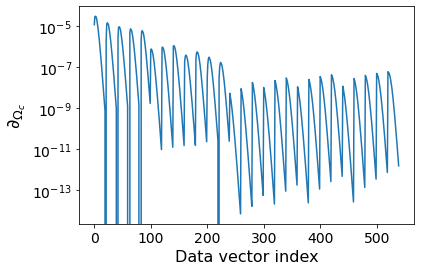

In [6]:
Omega_c_deriv_neg2 = numerical_deriv('Omega_c', 0.01)
Omega_c_deriv_neg3 = numerical_deriv('Omega_c', 0.001)
Omega_c_deriv_neg4 = numerical_deriv('Omega_c', 0.0001)

plt.plot(Omega_c_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{\Omega_c}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

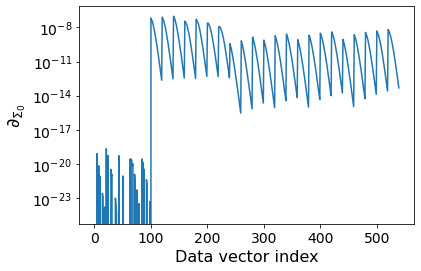

In [7]:
Sig_0_deriv_neg2 = numerical_deriv('sigma_0', 0.01)
Sig_0_deriv_neg3 = numerical_deriv('sigma_0', 0.001)
Sig_0_deriv_neg4 = numerical_deriv('sigma_0', 0.0001)

plt.plot(Sig_0_deriv_neg2)
plt.plot()
plt.yscale('log')
plt.ylabel('$\partial_{\Sigma_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

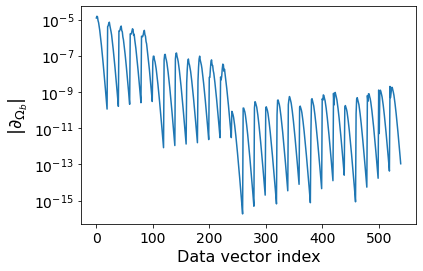

In [8]:
Omega_b_deriv_neg2 = numerical_deriv('Omega_b', 0.01)
Omega_b_deriv_neg3 = numerical_deriv('Omega_b', 0.001)
Omega_b_deriv_neg4 = numerical_deriv('Omega_b', 0.0001)

plt.plot(np.abs(Omega_b_deriv_neg2))
plt.yscale('log')
plt.ylabel('$|\partial_{\Omega_b}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

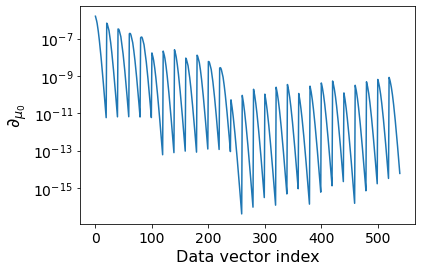

In [9]:
mu_0_deriv_neg2 = numerical_deriv('mu_0', 0.01)
mu_0_deriv_neg3 = numerical_deriv('mu_0', 0.001)
mu_0_deriv_neg4 = numerical_deriv('mu_0', 0.0001)

plt.plot(mu_0_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{\mu_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

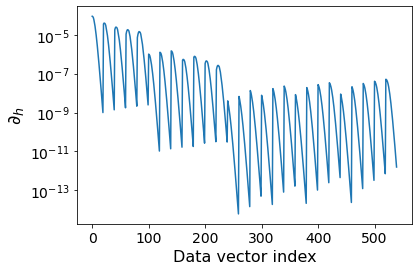

In [10]:
h_deriv_neg2 = numerical_deriv('h', 0.01)
h_deriv_neg3 = numerical_deriv('h', 0.001)
h_deriv_neg4 = numerical_deriv('h', 0.0001)


plt.plot(h_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{h}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

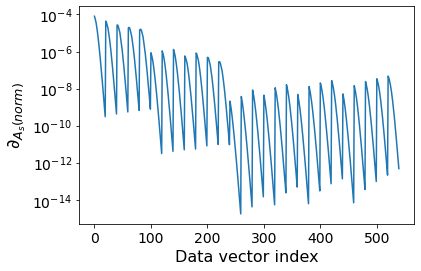

In [11]:
A_s_norm_deriv_neg2 = numerical_deriv('A_s_norm', 0.01 )
A_s_norm_deriv_neg3 = numerical_deriv('A_s_norm', 0.001 )
A_s_norm_deriv_neg4 = numerical_deriv('A_s_norm', 0.0001 )

plt.plot(A_s_norm_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{A_s(norm)}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

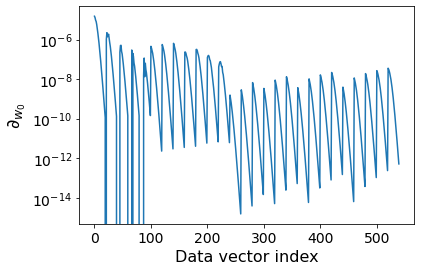

In [12]:
w0_deriv_neg2 = numerical_deriv('w0', 0.01)
w0_deriv_neg3 = numerical_deriv('w0', 0.001)
w0_deriv_neg4 = numerical_deriv('w0', 0.0001)

plt.plot(w0_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{w_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

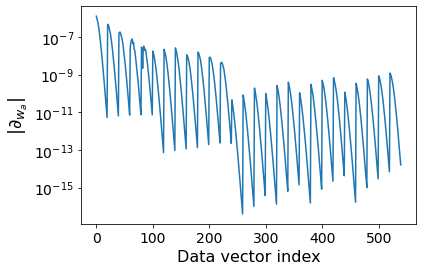

In [13]:
wa_deriv_neg2 = numerical_deriv('wa', 0.01)
wa_deriv_neg3 = numerical_deriv('wa', 0.001)
wa_deriv_neg4 = numerical_deriv('wa', 0.0001)

plt.plot(np.abs(wa_deriv_neg2))
plt.yscale('log')
plt.ylabel('$|\partial_{w_a}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

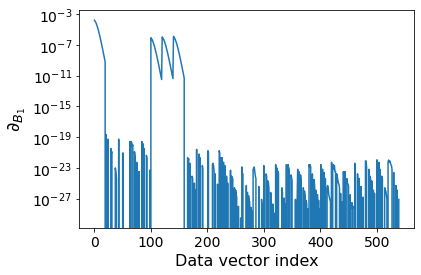

In [14]:
bias_1_deriv_neg2 = numerical_deriv('bias_1', 0.01)
bias_1_deriv_neg3 = numerical_deriv('bias_1', 0.001)
bias_1_deriv_neg4 = numerical_deriv('bias_1', 0.0001)

plt.plot(bias_1_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{B_1}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

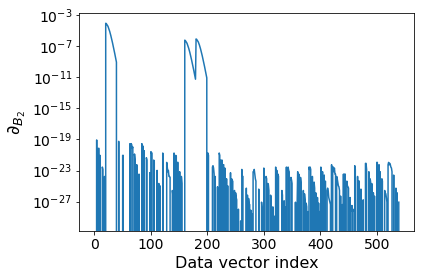

In [15]:
bias_2_deriv_neg2 = numerical_deriv('bias_2', 0.01)
bias_2_deriv_neg3 = numerical_deriv('bias_2', 0.001)
bias_2_deriv_neg4 = numerical_deriv('bias_2', 0.0001)


plt.plot(bias_2_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{B_2}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

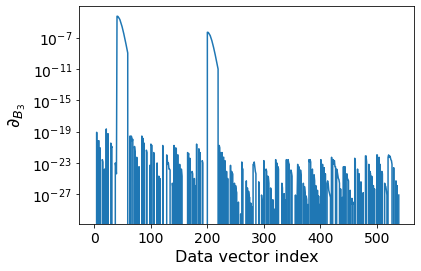

In [16]:
bias_3_deriv_neg2 = numerical_deriv('bias_3', 0.01)
bias_3_deriv_neg3 = numerical_deriv('bias_3', 0.001)
bias_3_deriv_neg4 = numerical_deriv('bias_3', 0.0001)

plt.plot(bias_3_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{B_3}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

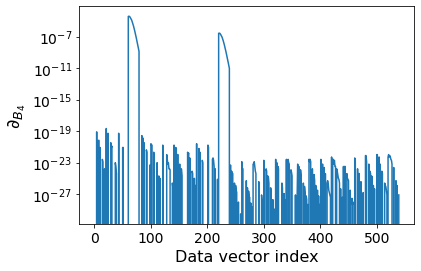

In [17]:
bias_4_deriv_neg2 = numerical_deriv('bias_4', 0.01)
bias_4_deriv_neg3 = numerical_deriv('bias_4', 0.001)
bias_4_deriv_neg4 = numerical_deriv('bias_4', 0.0001)

plt.plot(bias_4_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{B_4}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

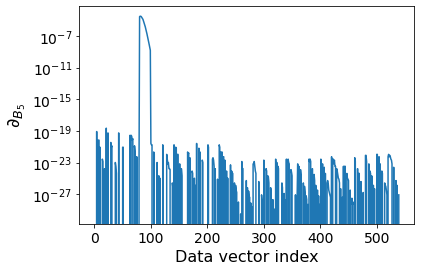

In [18]:
bias_5_deriv_neg2 = numerical_deriv('bias_5', 0.01)
bias_5_deriv_neg3 = numerical_deriv('bias_5', 0.001)
bias_5_deriv_neg4 = numerical_deriv('bias_5', 0.0001)

plt.plot(bias_5_deriv_neg2)
plt.yscale('log')
plt.ylabel('$\partial_{B_5}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

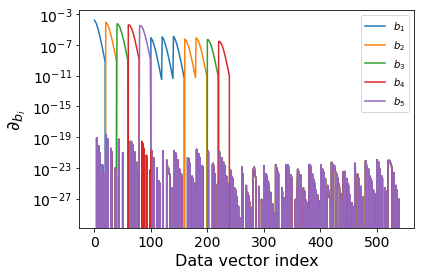

In [19]:
plt.plot(bias_1_deriv_neg2, label = '$b_1$')
plt.plot(bias_2_deriv_neg2, label = '$b_2$')
plt.plot(bias_3_deriv_neg2, label = '$b_3$')
plt.plot(bias_4_deriv_neg2, label = '$b_4$')
plt.plot(bias_5_deriv_neg2, label = '$b_5$')

plt.yscale('log')
plt.ylabel('$\partial_{b_i}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

plt.show()

# Start on Fisher matrix calculation
### Load in covariance matrix, multiply deriv by inv cov by deriv
#### Note : (omeg_c, omeg_b, h, sig8, bias, sig0, mu0, w0) is order we will be constructing this in

In [21]:
inv_cov = np.loadtxt('inv_cov_matrix') #read in the saved inverse covariance matrix
mask = np.loadtxt('scale_mask')
print(np.shape(mask))
print(np.shape(inv_cov))
print(inv_cov)

(705,)
(540, 540)
[[ 5.93063017e+18 -2.97754813e+16 -4.66205760e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.97754813e+16  1.27555122e+19 -7.41638895e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.66205760e+16 -7.41638895e+16  2.70979734e+19 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [22]:
#initialise a numpy array for our fisher matrices for h = 10^-2, 10^-3 and 10^-4 and for the LSST fisher matrix
fisher_neg2h = np.zeros(shape = (13,13))
fisher_neg3h = np.zeros(shape = (13,13))
fisher_neg4h = np.zeros(shape = (13,13))
fisher_LSST_Y1 = np.array([[4.321685e+05, 2.754616e+05, 5.992140e+04, -1.992358e+04, -4.473057e+03, -2.164983e+05, 5.264462e+04],
[2.754616e+05, 2.082198e+05, 2.691262e+04, -1.379929e+04, -3.407022e+03, -7.745383e+04, 1.946493e+04],
[5.992140e+04, 2.691262e+04, 2.414847e+04, -6.937346e+02, -1.056892e+02, -6.207807e+04, 1.576508e+04],
[-1.992358e+04, -1.379929e+04, -6.937346e+02, 1.395740e+03, 3.162361e+02, 4.976017e+03, -1.248729e+03],
[-4.473057e+03, -3.407022e+03, -1.056892e+02, 3.162361e+02, 8.081758e+01, 9.051103e+02, -2.218407e+02],
[-2.164983e+05, -7.745383e+04, -6.207807e+04, 4.976017e+03, 9.051103e+02, 3.877220e+05, -6.499201e+04],
[5.264462e+04, 1.946493e+04, 1.576508e+04, -1.248729e+03, -2.218407e+02, -6.499201e+04, 1.565908e+04]])

In [23]:
#Construct a dictionary that we can iterate through that contains our derivative data vectors
derivatives_neg2 = [Omega_c_deriv_neg2,\
               Omega_b_deriv_neg2,\
               h_deriv_neg2,\
               A_s_norm_deriv_neg2,\
               bias_1_deriv_neg2,\
               bias_2_deriv_neg2,\
               bias_3_deriv_neg2,\
               bias_4_deriv_neg2,\
               bias_5_deriv_neg2,\
               Sig_0_deriv_neg2,\
               mu_0_deriv_neg2,\
               w0_deriv_neg2,\
               wa_deriv_neg2]

derivatives_neg3 = [Omega_c_deriv_neg3,\
               Omega_b_deriv_neg3,\
               h_deriv_neg3,\
               A_s_norm_deriv_neg3,\
               bias_1_deriv_neg3,\
               bias_2_deriv_neg3,\
               bias_3_deriv_neg3,\
               bias_4_deriv_neg3,\
               bias_5_deriv_neg3,\
               Sig_0_deriv_neg3,\
               mu_0_deriv_neg3,\
               w0_deriv_neg3,\
               wa_deriv_neg3]

derivatives_neg4 = [Omega_c_deriv_neg4,\
               Omega_b_deriv_neg4,\
               h_deriv_neg4,\
               A_s_norm_deriv_neg4,\
               bias_1_deriv_neg4,\
               bias_2_deriv_neg4,\
               bias_3_deriv_neg4,\
               bias_4_deriv_neg4,\
               bias_5_deriv_neg4,\
               Sig_0_deriv_neg4,\
               mu_0_deriv_neg4,\
               w0_deriv_neg4,\
               wa_deriv_neg4]


In [24]:
#apply mask to derivative vector
for i in range(len(derivatives_neg2)):
    for j in range(540):
        derivatives_neg2[i][j] = derivatives_neg2[i][j]*mask[j]

In [25]:
#Script to construct the fisher matrix, looping over the parameter values

for i in range(len(derivatives_neg2)):
    for j in range(len(derivatives_neg2)):
        fisher_neg2h[i][j] = np.matmul(derivatives_neg2[i], (np.matmul(inv_cov, derivatives_neg2[j])))
    
for i in range(len(derivatives_neg3)):
    for j in range(len(derivatives_neg3)):
        fisher_neg3h[i][j] = np.matmul(derivatives_neg3[i], (np.matmul(inv_cov, derivatives_neg3[j])))

for i in range(len(derivatives_neg4)):
    for j in range(len(derivatives_neg4)):
        fisher_neg4h[i][j] = np.matmul(derivatives_neg4[i], (np.matmul(inv_cov, derivatives_neg4[j])))

In [26]:
print(fisher_neg2h)
print(np.shape(fisher_neg2h))
print(np.shape(fisher_LSST_Y1))

[[ 4.71928509e+11 -1.23325542e+11  8.35729531e+11  3.69257945e+11
   4.03148866e+11  2.18047842e+11  7.86270287e+10  2.71653418e+10
   1.32857749e+10 -1.12700008e+08  6.32996861e+09  8.35420702e+10
  -5.50099249e+09]
 [-1.23325542e+11  3.67308003e+10 -2.36287573e+11 -1.12324417e+11
  -1.24587300e+11 -7.19179864e+10 -2.07764962e+10 -8.41470097e+09
   5.15677905e+08  3.49175007e+07 -1.95562134e+09 -2.26700880e+10
   1.65557333e+09]
 [ 8.35729531e+11 -2.36287573e+11  1.58368204e+12  7.48912917e+11
   7.99720321e+11  4.79445120e+11  1.59960128e+11  4.83913431e+10
   1.39268585e+10 -2.36402884e+08  1.28859208e+10  1.53017572e+11
  -1.09766574e+10]
 [ 3.69257945e+11 -1.12324417e+11  7.48912917e+11  3.79743357e+11
   3.91183186e+11  2.54468081e+11  8.57042495e+10  2.41749211e+10
   5.79088437e+09 -1.21369470e+08  6.50851337e+09  7.03943384e+10
  -5.46109444e+09]
 [ 4.03148866e+11 -1.24587300e+11  7.99720321e+11  3.91183186e+11
   1.34033215e+12 -3.53067119e+11 -1.51144829e+11 -5.57305527e+10


In [27]:
sig_1_dev = []
for i in range(8):
    sig_1_dev.append((np.sqrt(fisher_neg2h[i][i]))**(-1))
    
print(sig_1_dev)

[1.4556665197388909e-06, 5.217768472697778e-06, 7.946319146180482e-07, 1.6227622920865803e-06, 8.637613791786537e-07, 8.586665082810015e-07, 1.0126517660185433e-06, 1.1495921898238805e-06]


In [28]:
#parameter covariance matrix is inverse of the fisher matrix
param_cov_neg2 = np.linalg.inv(fisher_neg2h)

param_cov_neg3 = np.linalg.inv(fisher_neg3h)

param_cov_neg4 = np.linalg.inv(fisher_neg4h)

param_cov_LSST_Y1 = np.linalg.inv(fisher_LSST_Y1)

In [30]:
print(param_cov_neg2)
print(param_cov_LSST_Y1)

[[ 1.01383648e-07  9.97386599e-08 -5.15620367e-08  2.00564736e-07
  -8.41679177e-07 -6.90974800e-07 -5.68592046e-07 -4.73604173e-07
  -4.00398014e-07 -1.12743887e-05  7.36541341e-05 -3.44528922e-07
  -8.66215583e-06]
 [ 9.97386599e-08  9.94197662e-08 -5.04038619e-08  1.99017643e-07
  -8.34117911e-07 -6.84789507e-07 -5.63544211e-07 -4.69448056e-07
  -3.96940991e-07 -1.11713486e-05  7.29767620e-05 -3.39726083e-07
  -8.53212992e-06]
 [-5.15620367e-08 -5.04038619e-08  2.63329777e-08 -1.01651708e-07
   4.26182917e-07  3.49874420e-07  2.87904008e-07  2.39803774e-07
   2.02731635e-07  5.70966365e-06 -3.72979676e-05  1.74764023e-07
   4.39286128e-06]
 [ 2.00564736e-07  1.99017643e-07 -1.01651708e-07  1.17665460e-06
  -2.15350769e-06 -1.83273853e-06 -1.57366799e-06 -1.37343425e-06
  -1.21946895e-06 -2.87681870e-05  1.57020769e-04 -6.40408071e-07
  -1.48575769e-05]
 [-8.41679177e-07 -8.34117911e-07  4.26182917e-07 -2.15350769e-06
   7.43418348e-06  6.13783668e-06  5.08746673e-06  4.27348174e-06


In [32]:
pos_or_neg = []

for i in range(8):
    if param_cov_neg2[i][i] < 0:
        pos_or_neg.append('neg')
    else:
        pos_or_neg.append('pos')
        
print(pos_or_neg)

['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']


In [33]:
print(np.linalg.eig(param_cov_neg2)[0]) #ensure that all eigenvalues of the parameter covariance matrix are positive

[5.72955180e-02 1.30593657e-04 3.22179085e-05 1.30965637e-07
 3.79635980e-09 9.88300022e-10 3.48170424e-10 1.42421842e-11
 2.67528770e-12 1.13538494e-12 3.23887433e-13 8.37873589e-13
 5.85356587e-13]


In [34]:
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist

In [35]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean = [0.27, 0.045, 0.67, 2.1, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, 0, 0, -0.9, 0.0]


param_names = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'B1', 'B2', 'B3', 'B4', 'B5,' 'Sigma_0', 'mu_0', 'w0', 'wa']

labels = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']


gauss_neg2=GaussianND(param_mean, param_cov_neg2, labels = labels, names = param_names)

gauss_neg3=GaussianND(param_mean, param_cov_neg3, labels = labels, names = param_names)

gauss_neg4=GaussianND(param_mean, param_cov_neg4, labels = labels, names = param_names)

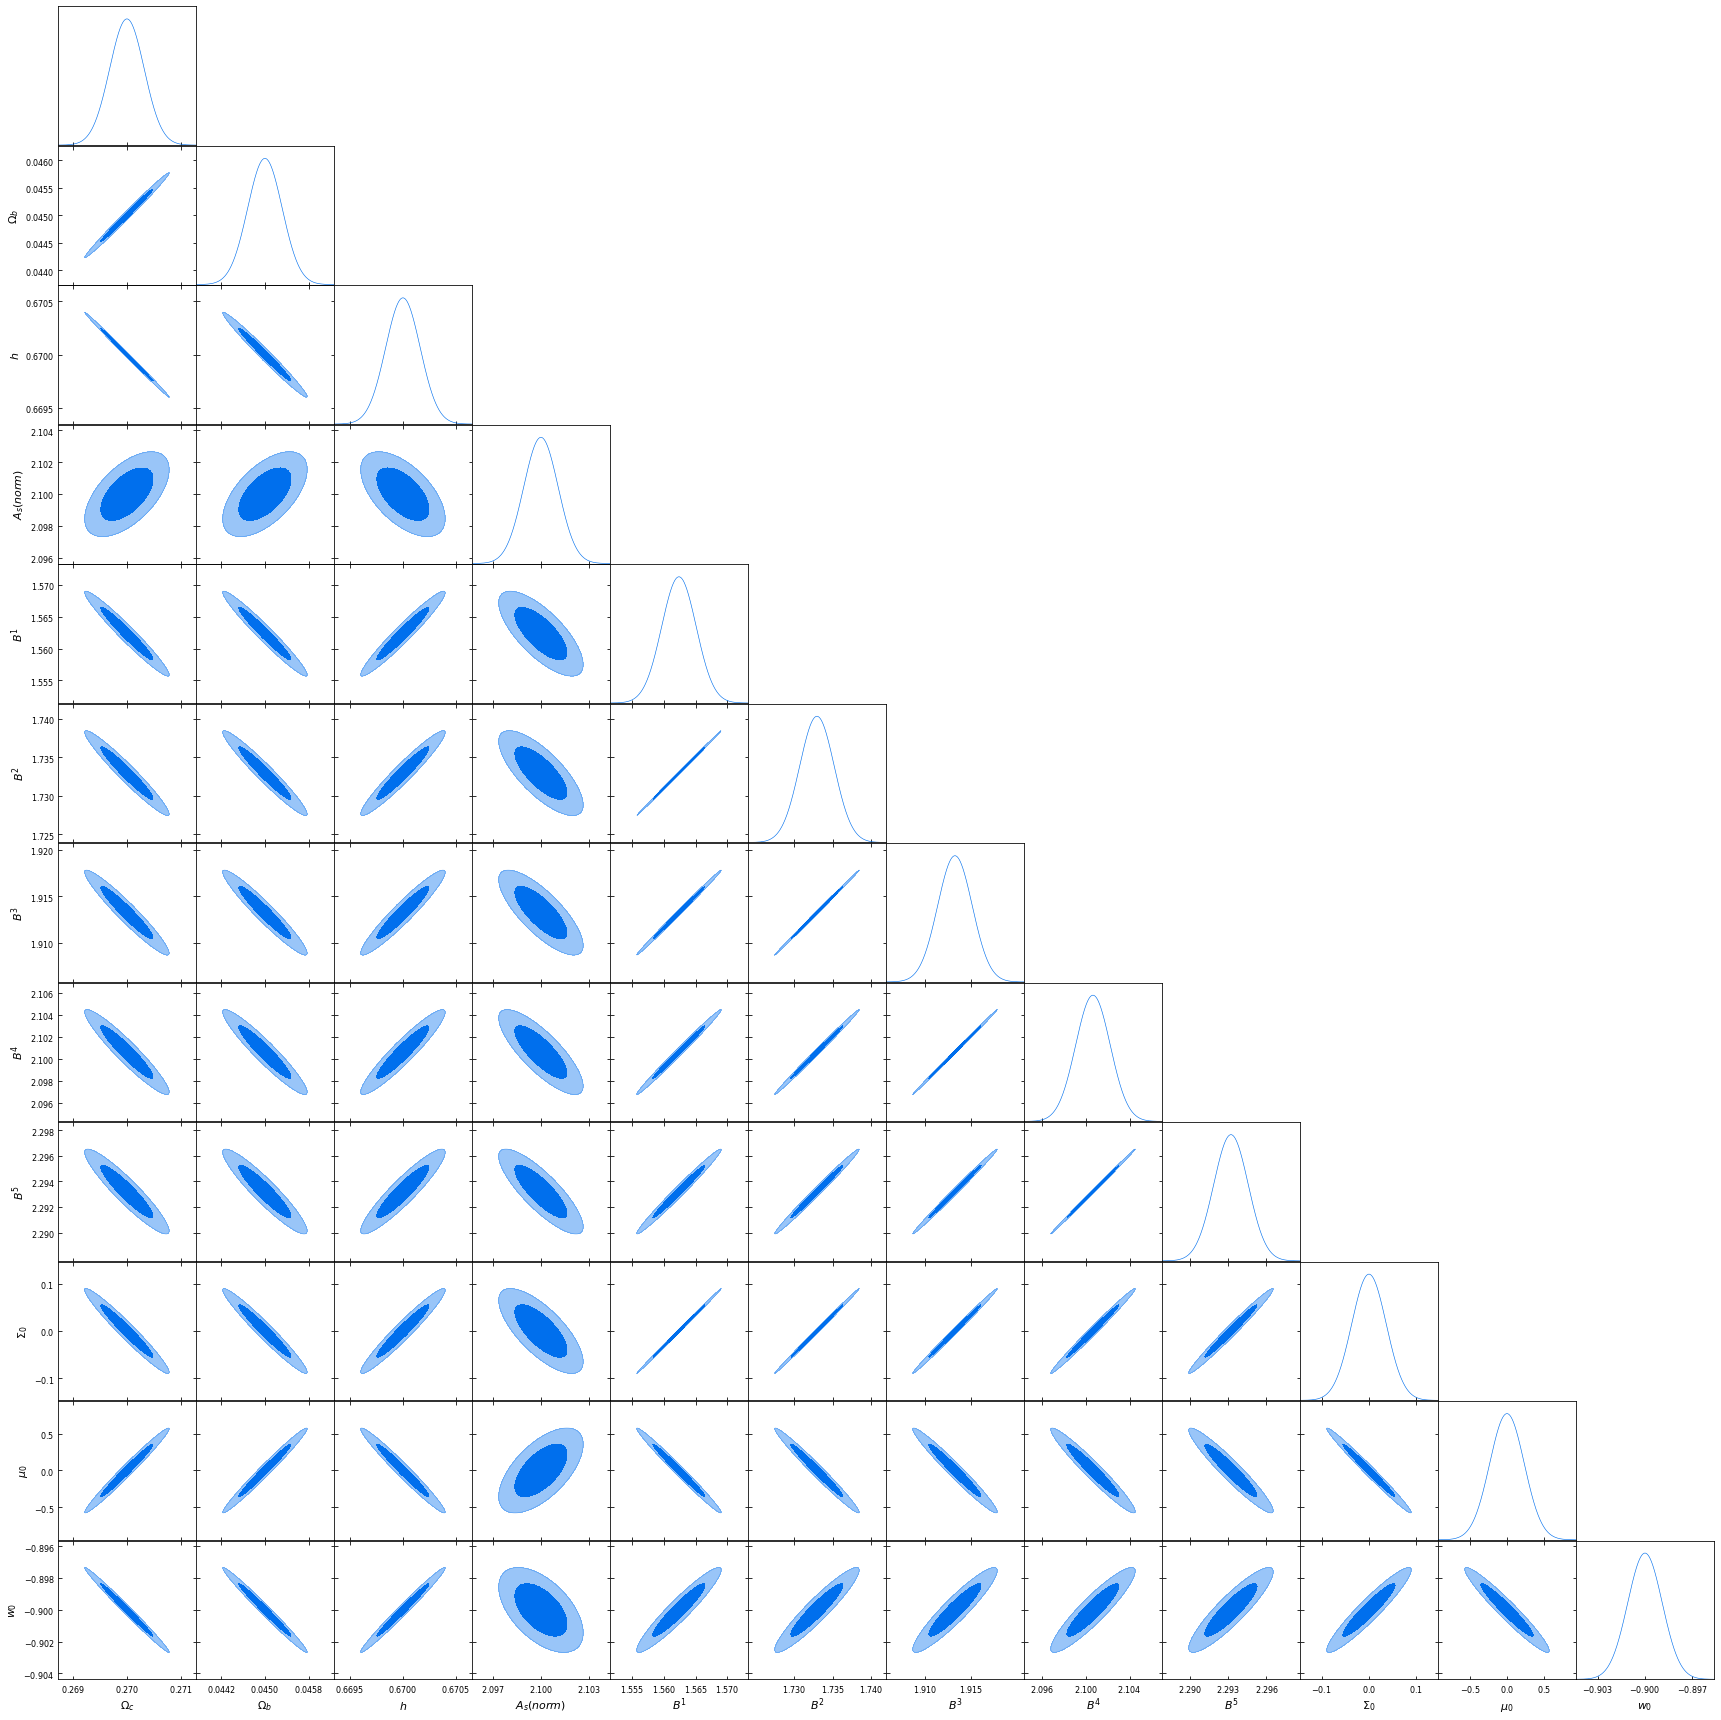

In [36]:
g = plots.get_subplot_plotter()
g.triangle_plot(gauss_neg2, filled = True)

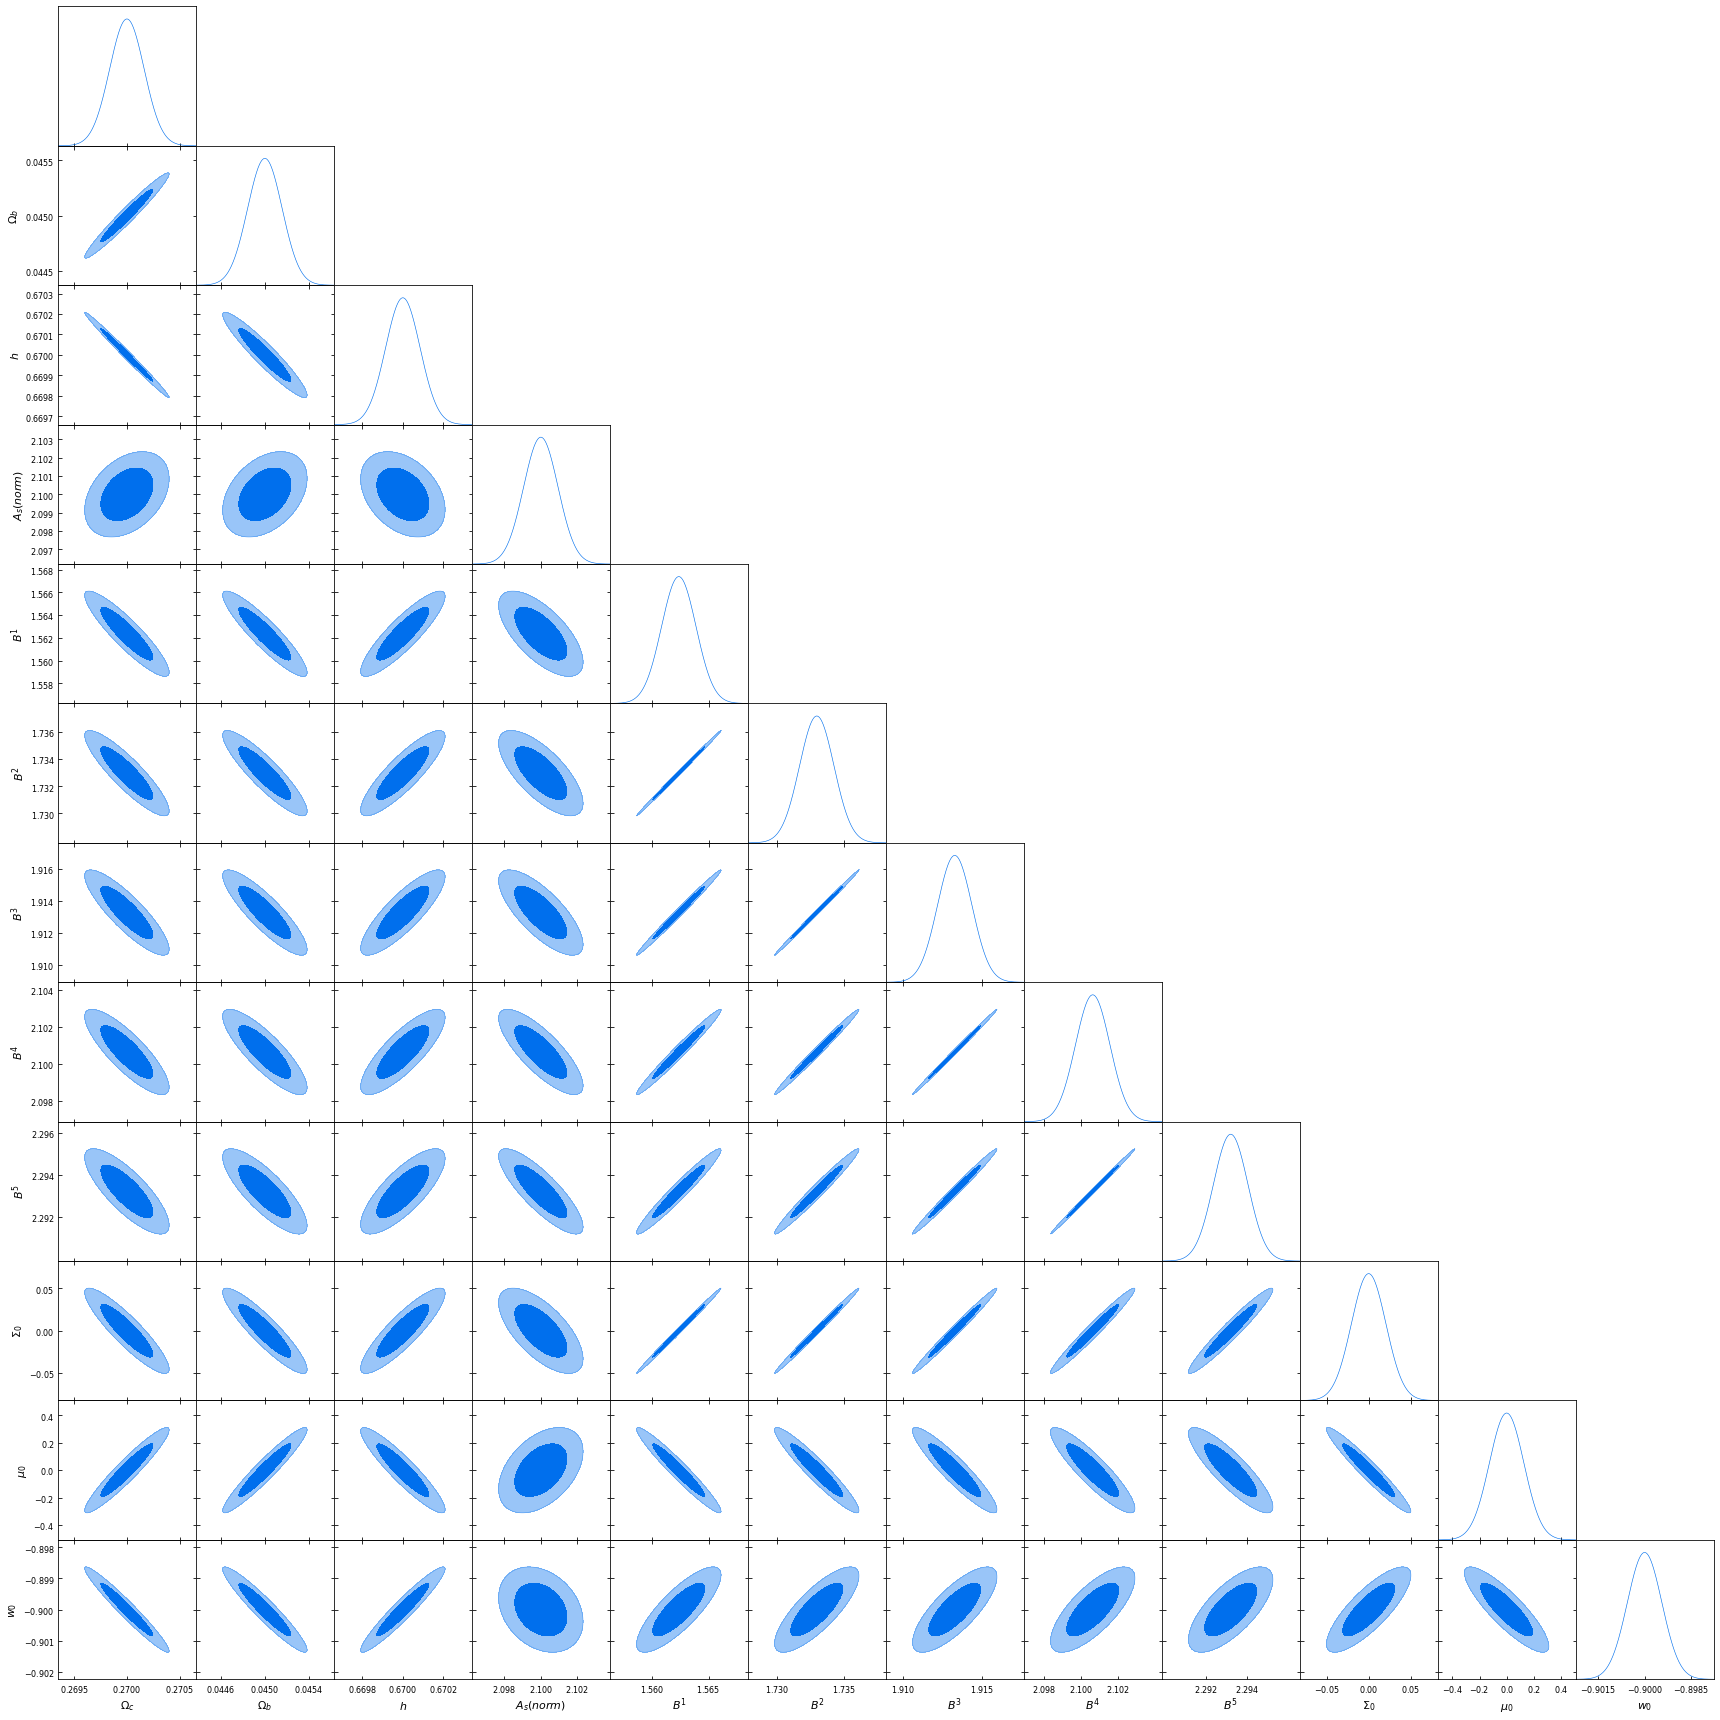

In [37]:
g.triangle_plot(gauss_neg3, filled = True)

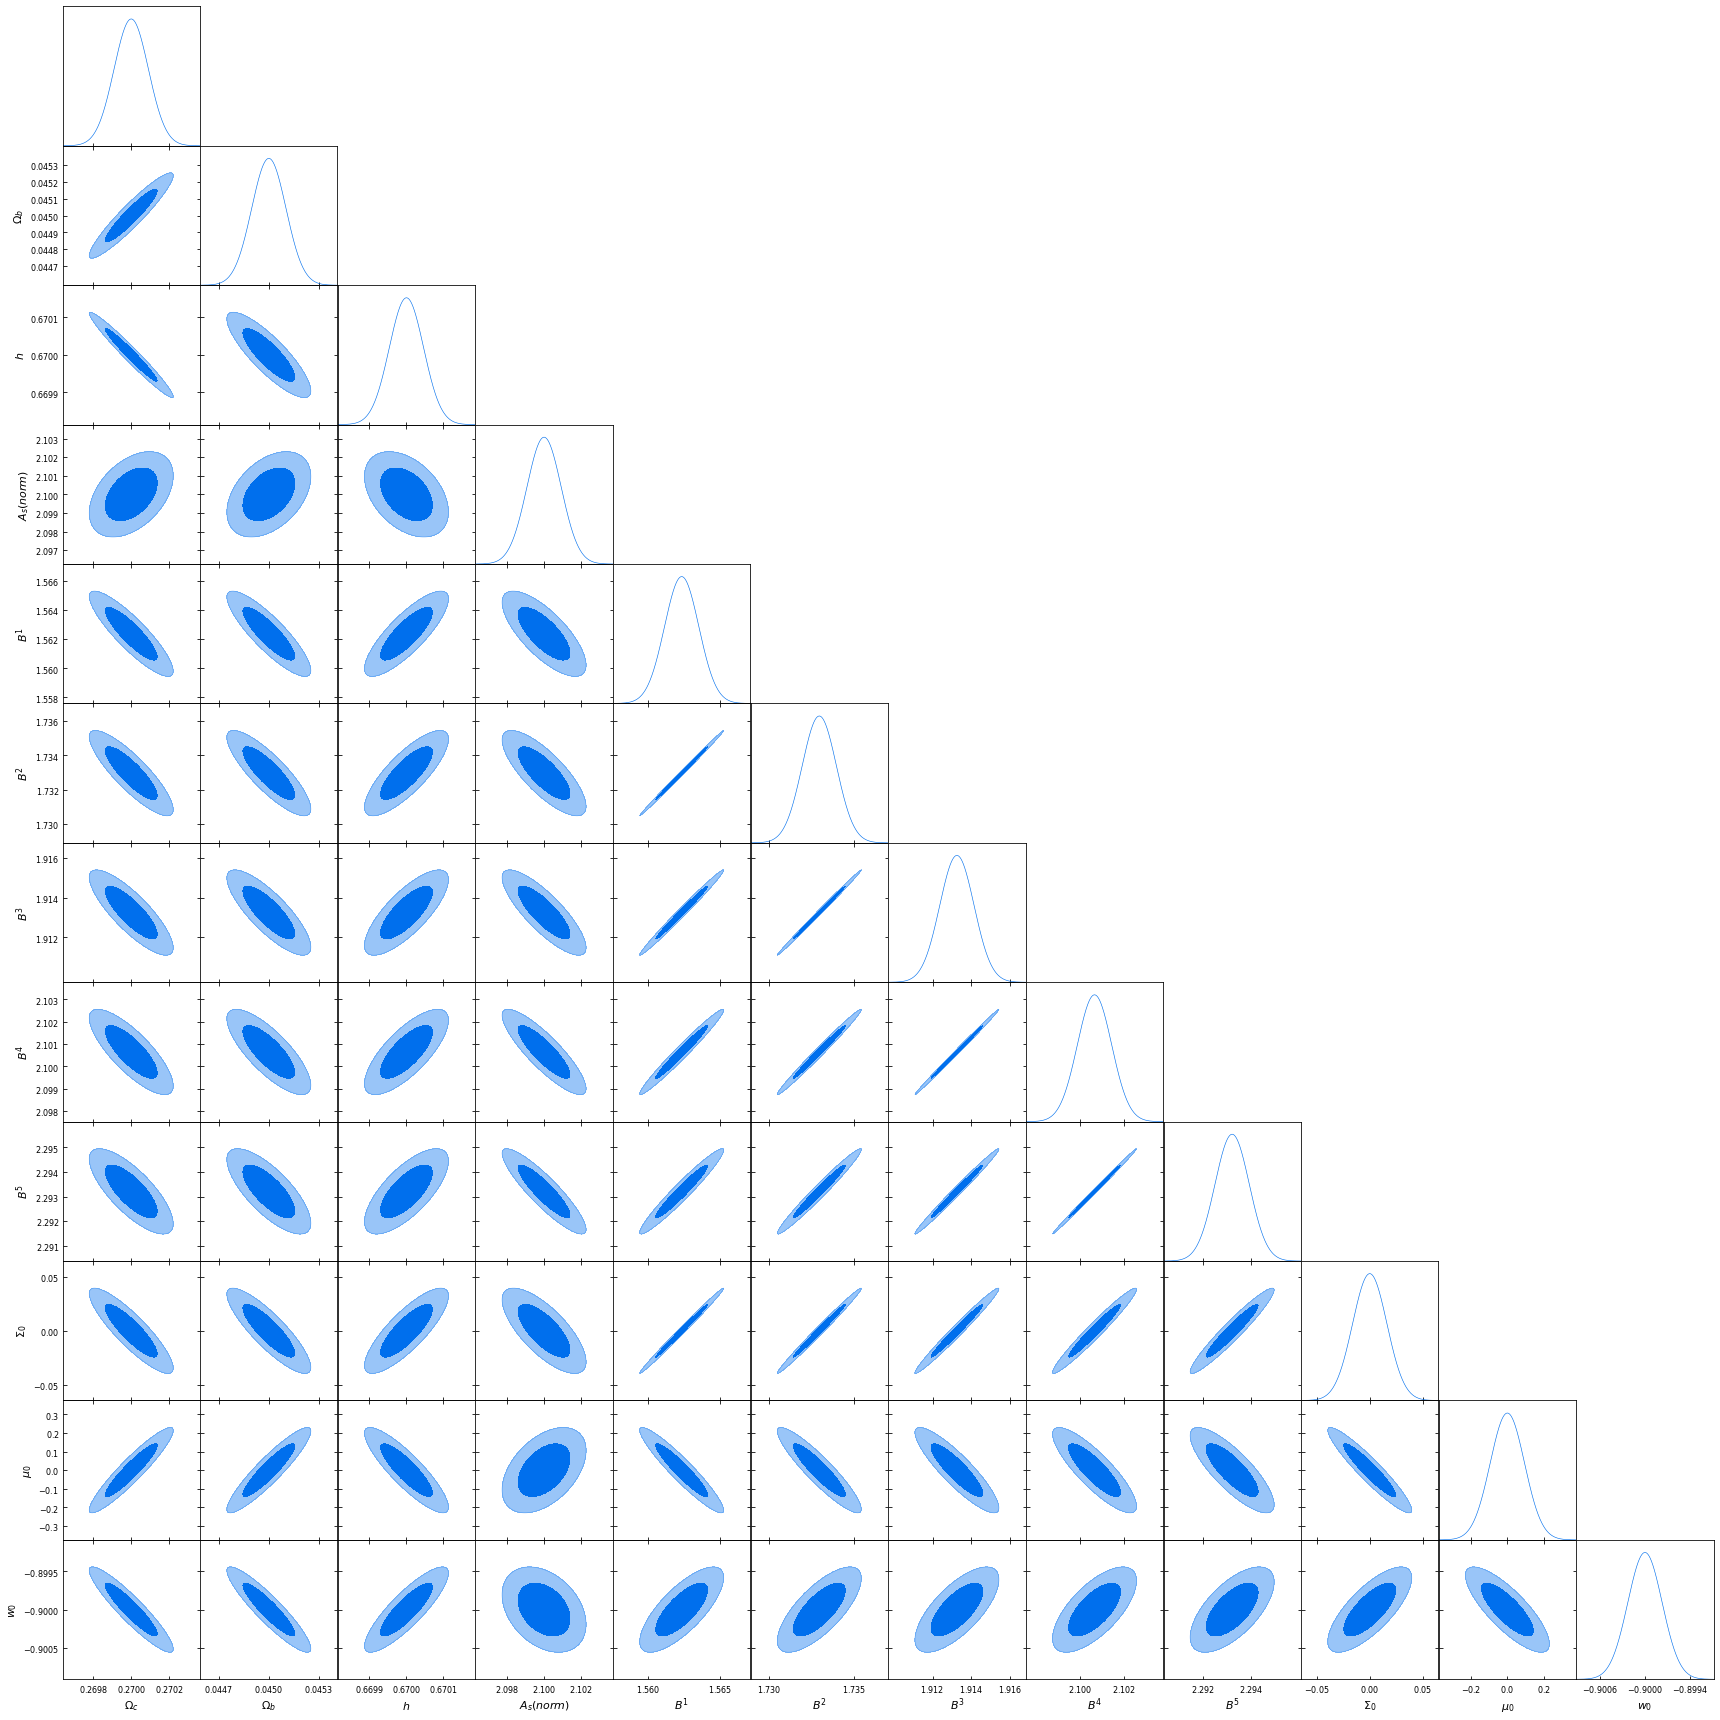

In [38]:
g.triangle_plot(gauss_neg4, filled = True)

In [39]:
param_names_2 = ['Omega_m', 'sigma8', 'n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_2 = [r'\Omega_{m}', r'\sigma_{8}', r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_2 = [0.27, 0.83, 0.96, -0.9, 0.0, 0.0450, 0.67]

gauss_2 = GaussianND(mean_2 ,param_cov_LSST_Y1, labels = labels_2, names = param_names_2)

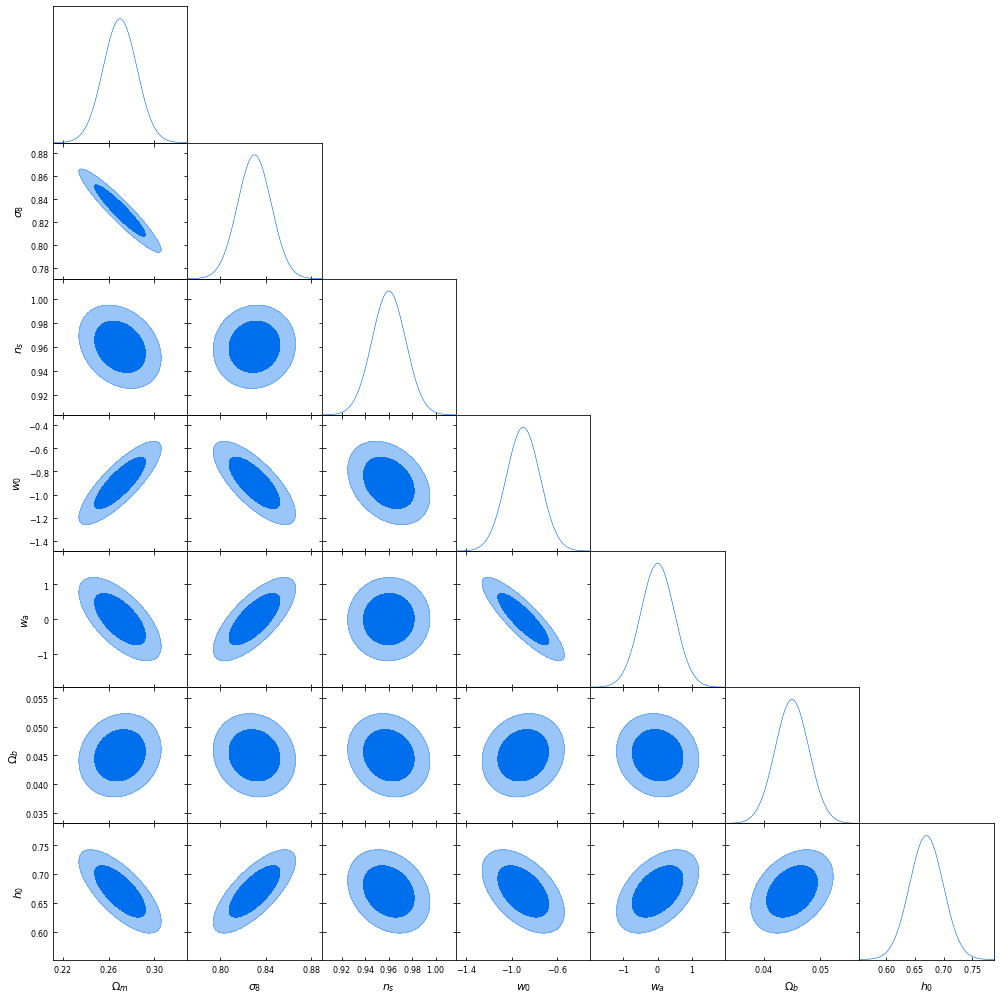

In [40]:
g.triangle_plot(gauss_2, filled = True)

In [41]:
sig_1_dev_LSST = []
for i in range(7):
    sig_1_dev_LSST.append(np.sqrt(param_cov_LSST_Y1[i][i]))
    
print(sig_1_dev_LSST)
    

[0.014628916142254098, 0.014800466268441798, 0.014207047529812208, 0.1472008302752674, 0.49135197731516833, 0.002965256870445557, 0.029459621868457755]


In [42]:
param_cov_cleaned = param_cov_neg2
param_cov_cleaned_test = np.delete(param_cov_cleaned, 1, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 1, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 1, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 1, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 1)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 0)
param_cov_cleaned_test = np.delete(param_cov_cleaned_test, 2, 1)
print(np.shape(param_cov_cleaned_test))

(6, 6)


In [43]:
sig_1_dev_clean = []

for i in range(6):
    sig_1_dev_clean.append(np.sqrt(param_cov_cleaned_test[i][i]))
    
print(sig_1_dev_clean)

[0.0003184079898331453, 0.0010847371113972745, 0.0365637284301552, 0.23516481014559867, 0.0010915519319754556, 0.028215994142994177]


In [44]:
param_mean_clean = [0.27, 2.1, 0, 0, -0.9, 0.0]
param_names_clean = ['Omega_c','A_s_norm','Sigma_0', 'mu_0', 'w0', 'wa']
param_labels_clean = [r'\Omega_{c}', r'A_{s}(norm)',r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']

gauss_clean = GaussianND(param_mean_clean, param_cov_cleaned_test, labels = param_labels_clean, names = param_names_clean)

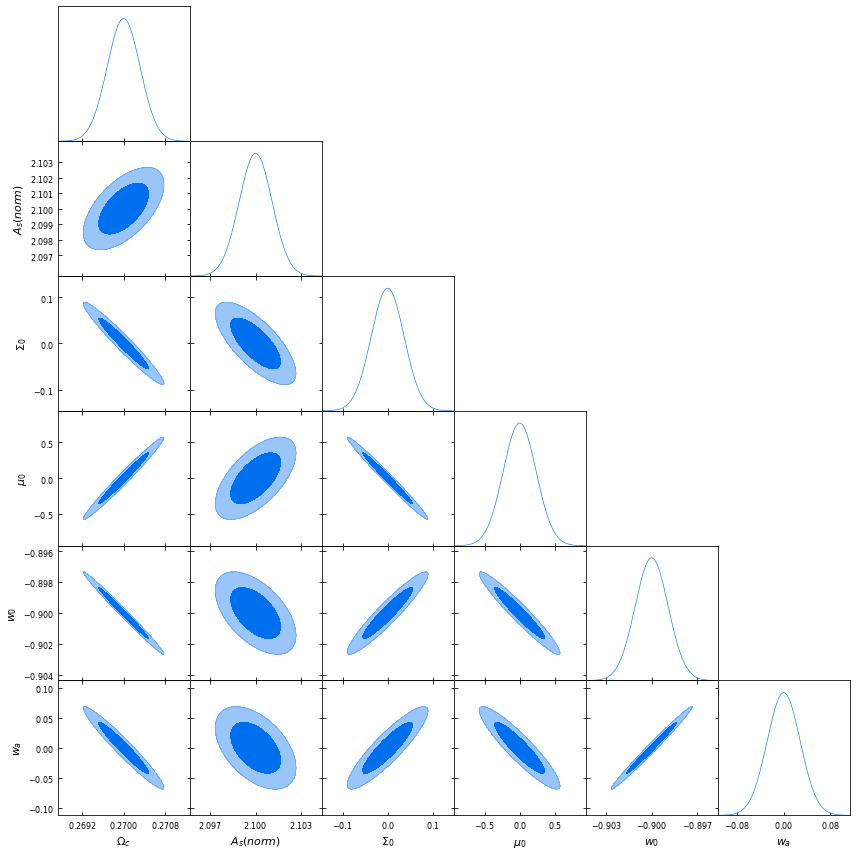

In [45]:
g.triangle_plot(gauss_clean, filled = True)

In [46]:
omega_c_deriv_test = numerical_deriv('Omega_c', 0.025)
omega_b_deriv_test = numerical_deriv('Omega_b', 0.025)
h_deriv_test = numerical_deriv('h', 0.025)
A_s_norm_deriv_test = numerical_deriv('A_s_norm', 0.025)
Bias_1_deriv_test = numerical_deriv('bias_1', 0.025)
Bias_2_deriv_test = numerical_deriv('bias_2', 0.025)
Bias_3_deriv_test = numerical_deriv('bias_3', 0.025)
Bias_4_deriv_test = numerical_deriv('bias_4', 0.025)
Bias_5_deriv_test = numerical_deriv('bias_5', 0.025)
Sig_0_deriv_test = numerical_deriv('sigma_0', 0.025)
mu_0_deriv_test = numerical_deriv('mu_0', 0.025)
w0_deriv_test = numerical_deriv('w0', 0.025)
wa_deriv_test = numerical_deriv('wa', 0.025)


In [47]:
derivatives_test = [omega_c_deriv_test,\
               omega_b_deriv_test,\
               h_deriv_test,\
               A_s_norm_deriv_test,\
               Bias_1_deriv_test,\
               Bias_2_deriv_test,\
               Bias_3_deriv_test,\
               Bias_4_deriv_test,\
               Bias_5_deriv_test,\
               Sig_0_deriv_test,\
               mu_0_deriv_test,\
               w0_deriv_test,\
               wa_deriv_test]


In [48]:
fisher_test = np.zeros(shape = (13,13))

In [49]:
for i in range(len(derivatives_test)):
    for j in range(len(derivatives_test)):
        fisher_test[i][j] = np.matmul(derivatives_test[i], (np.matmul(inv_cov, derivatives_test[j])))

In [50]:
param_cov_test = np.linalg.inv(fisher_test)

In [51]:
gauss_neg_test=GaussianND(param_mean, param_cov_test, labels = labels, names = param_names)

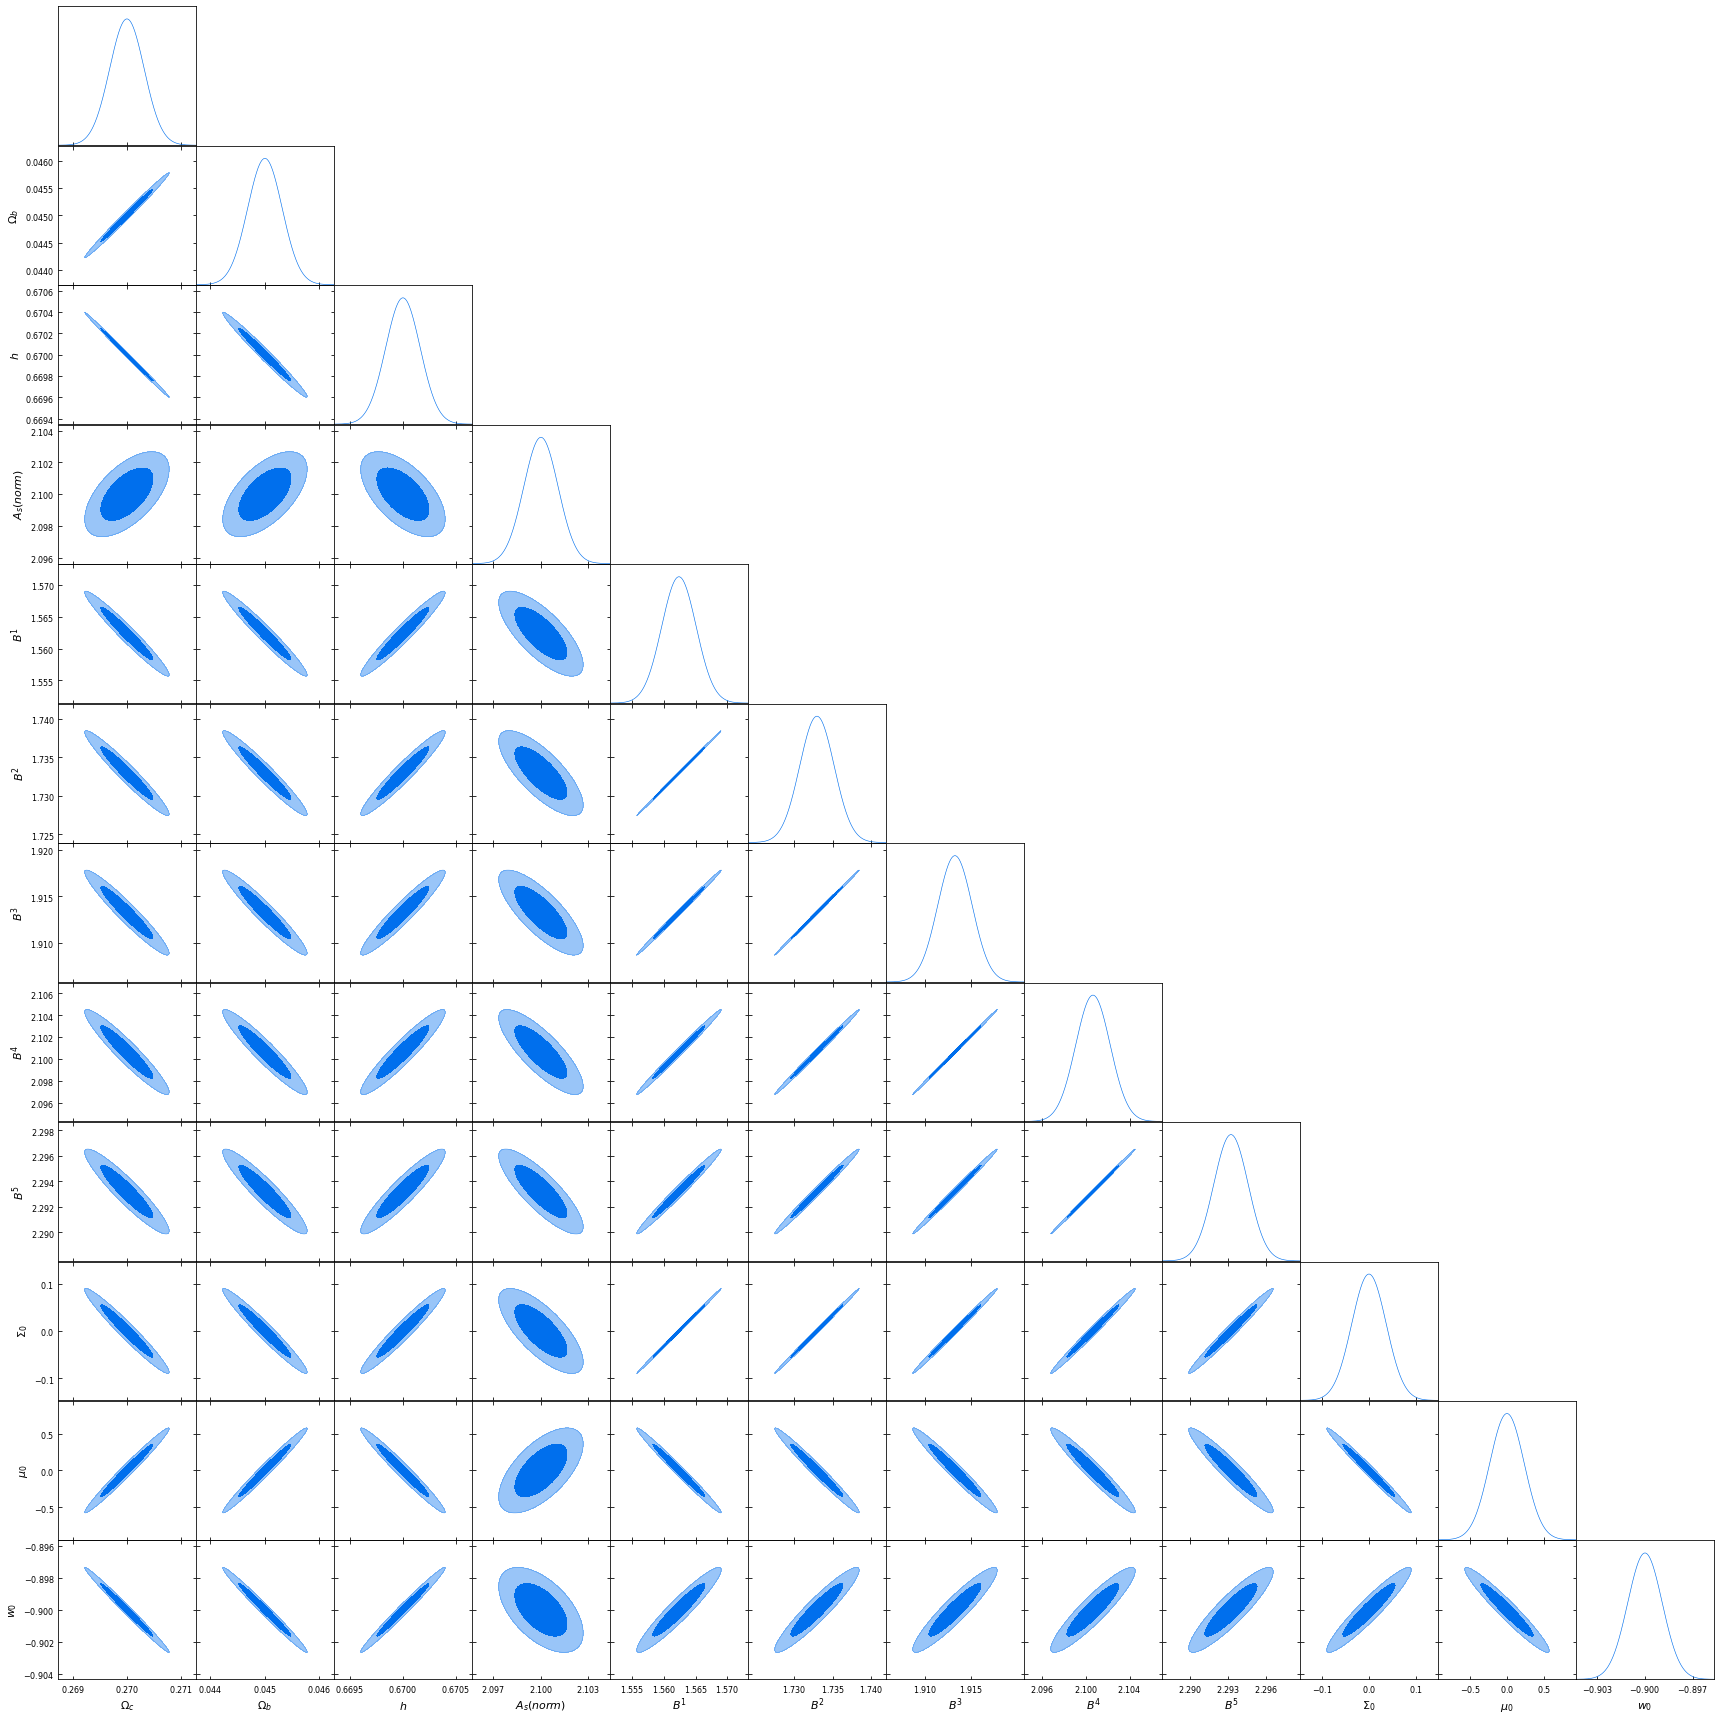

In [52]:
g.triangle_plot(gauss_neg_test, filled = True)

In [53]:
param_cov_cleaned_2 = param_cov_test
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_2, 1, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 1, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 1, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 1, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 1)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 0)
param_cov_cleaned_test_2 = np.delete(param_cov_cleaned_test_2, 2, 1)
print(np.shape(param_cov_cleaned_test_2))

(6, 6)


In [54]:
gauss_clean_test = GaussianND(param_mean_clean, param_cov_cleaned_test_2, labels = param_labels_clean, names = param_names_clean)

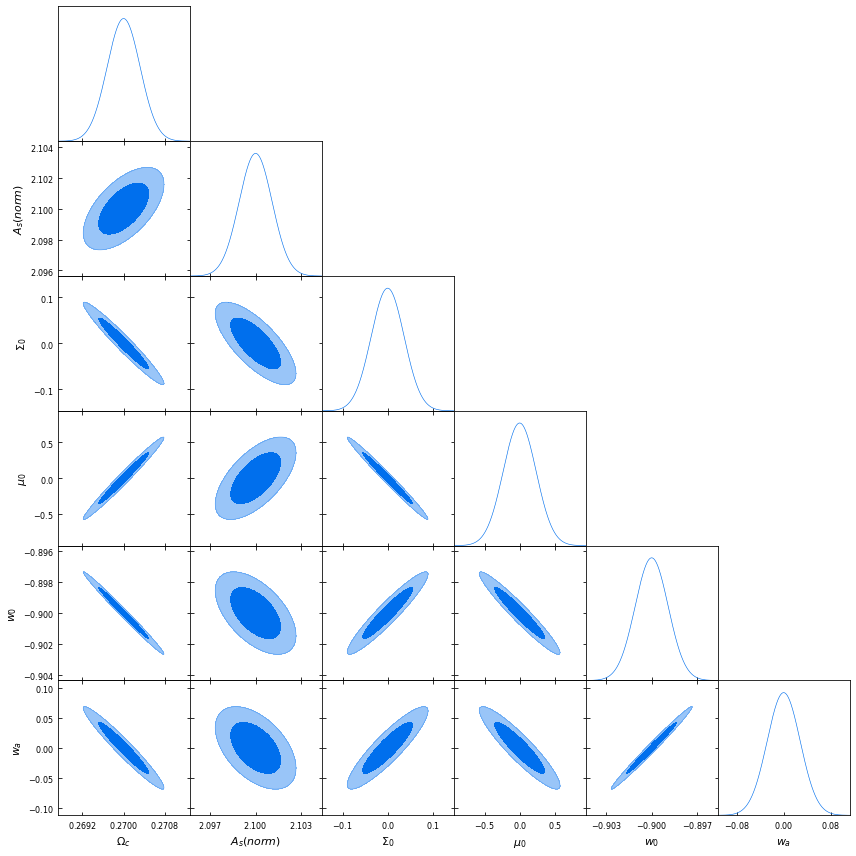

In [55]:
g.triangle_plot(gauss_clean_test, filled = True)